# Data Ingest

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("silviamatoke/serengeti-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.42G/9.42G [01:04<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/silviamatoke/serengeti-dataset/versions/1


In [2]:
!mv /root/.cache/kagglehub/datasets/silviamatoke/serengeti-dataset/versions/1 /content/dataset

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import pandas as pd
import numpy as np
import string
import tensorflow as tf

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, Dropout, Flatten, Activation, Conv2D,
    MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
)

from sklearn.preprocessing import LabelEncoder

import os

sns.set_theme()


# Labels Preprocessing

In [4]:
labels_path = "/content/labels.csv" # pull from github

labels_df = pd.read_csv(labels_path)
labels_df.head()

,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4,b1,...,f3,f4,g1,g2,g3,g4,h1,h2,h3,h4
0,1.02-Agouti/SEQ75520/SEQ75520_IMG_0001.JPG,Agouti,SEQ75520,SEQ75520_IMG0001.JPG,1,1121.0,841.0,1392.0,1051.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.02-Agouti/SEQ75520/SEQ75520_IMG_0002.JPG,Agouti,SEQ75520,SEQ75520_IMG0002.JPG,1,1227.0,825.0,1537.0,1054.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.02-Agouti/SEQ75520/SEQ75520_IMG_0003.JPG,Agouti,SEQ75520,SEQ75520_IMG0003.JPG,1,1401.0,788.0,1734.0,1027.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.02-Agouti/SEQ75520/SEQ75520_IMG_0004.JPG,Agouti,SEQ75520,SEQ75520_IMG0004.JPG,1,1619.0,757.0,1916.0,984.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.02-Agouti/SEQ75520/SEQ75520_IMG_0005.JPG,Agouti,SEQ75520,SEQ75520_IMG0005.JPG,1,1780.0,714.0,1918.0,918.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
labels_df.shape

(1277, 37)

In [8]:
unlabeled_path_base = "/content/dataset/Set1/1.58-Roe_Deer/SEQ767"
unlabeled_files = os.listdir(unlabeled_path_base)
unlabeled_filepaths = np.array([unlabeled_path_base + "/" + file for file in unlabeled_files])

In [9]:
path_base = "/content/dataset/Set1/"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

# isolating images that contain animals
positives = labels_df[labels_df["animal_count"] > 0]

filepaths = path_base + positives["file_path"].values

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(positives["animal"].values).astype('int32')

# only using the first bounding box as others are duplicates
bbox_array = positives[['a1', 'a2', 'a3', 'a4']].values.astype('float32')

# function to load and preprocess image
def load_and_preprocess(path, label, bbox=None):

    image_bytes = tf.io.read_file(path)

    # check if file is a valid JPEG
    is_jpeg = tf.image.is_jpeg(image_bytes)

    # if file is not valid, class is set to -1 and filtered out
    def invalid():
        return (
            tf.zeros(IMAGE_SIZE + (3,)),
            {"class_output": -1, "bbox_output": tf.zeros((4,))},
            path
        )

    def valid():
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = tf.image.convert_image_dtype(image, tf.float32)

        # normalize bounding box for resized image
        h = tf.cast(tf.shape(image)[0], tf.float32)
        w = tf.cast(tf.shape(image)[1], tf.float32)
        if bbox is not None:
          bbox_norm = bbox / [w, h, w, h]
        else:
          bbox_norm = tf.zeros((4,))

        bbox_norm = tf.cast(bbox_norm, tf.float32)

        return (
            image,
            {"class_output": label, "bbox_output": bbox_norm},
            path
        )

    return tf.cond(is_jpeg, valid, invalid)

# calling pipeline
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels, bbox_array))
ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
ds = ds.filter(lambda image, labels, path: labels["class_output"] != -1)
ds = ds.apply(tf.data.Dataset.ignore_errors)

# creating seperate datasets with unlabeled images
f = unlabeled_filepaths.shape[0]

ds_u = tf.data.Dataset.from_tensor_slices((unlabeled_filepaths, (labels[:f]*0)+13, bbox_array[:f]*0))
ds_u = ds_u.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

# Data Splitting

In [30]:
# determine split sizes
n = positives.shape[0]
train_size = int(0.8 * n)
val_size = int(0.1 * n)

raw_ds = ds.shuffle(500, seed=1337)

train_raw = raw_ds.take(train_size)
val_raw   = raw_ds.skip(train_size).take(val_size)
test_raw  = raw_ds.skip(train_size + val_size)

train_ds = train_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = test_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Basic CNN

In [31]:
NUM_CLASSES = len(label_encoder.classes_)
input_shape = IMAGE_SIZE + (3,)

# multi-output cnn
inputs = Input(shape=input_shape, name="image_input")

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)

# prediction head - classification
class_output = Dense(NUM_CLASSES, activation='softmax', name="class_output")(x)

# prediction head - bounding box regression
bbox_output = Dense(4, activation='linear', name="bbox_output")(x)

# model compilation with two loss functions
model = Model(inputs=inputs, outputs=[class_output, bbox_output])

model.compile(
    optimizer='adam',
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "bbox_output": "mse"
    },
    loss_weights={
        "class_output": 1.0,
        "bbox_output": 1.0
    },
    metrics={
        "class_output": "accuracy",
        "bbox_output": "mse"
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        128 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 26, 26,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 43264)     │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │ 22,151,680 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 19)        │      9,747 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      2,052 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,229,559 (84.80 MB)

 Trainable params: 22,229,303 (84.80 MB)

 Non-trainable params: 256 (1.00 KB)

In [32]:
model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
     24/Unknown 11s 161ms/step - bbox_output_loss: 1239.5134 - bbox_output_mse: 1239.7704 - class_output_accuracy: 0.0548 - class_output_loss: 8.3099 - loss: 1248.0817

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - bbox_output_loss: 1209.6246 - bbox_output_mse: 1210.1182 - class_output_accuracy: 0.0562 - class_output_loss: 8.2231 - loss: 1218.3436 - val_bbox_output_loss: 64.5177 - val_bbox_output_mse: 64.5097 - val_class_output_accuracy: 0.1064 - val_class_output_loss: 3.1324 - val_loss: 67.6477
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - bbox_output_loss: 51.8542 - bbox_output_mse: 51.8872 - class_output_accuracy: 0.1038 - class_output_loss: 4.8660 - loss: 56.7518 - val_bbox_output_loss: 22.1132 - val_bbox_output_mse: 22.0751 - val_class_output_accuracy: 0.0319 - val_class_output_loss: 7.2020 - val_loss: 29.2562
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - bbox_output_loss: 11.8009 - bbox_output_mse: 11.8041 - class_output_accuracy: 0.1195 - class_output_loss: 8.6994 - loss: 20.5047 - val_bbox_output_loss: 26.7848 - val_bbox_output_mse: 26.6820 - val_class_output_accuracy: 0.0319 - val_class_output_loss: 3.6527 - val_loss: 30.3437


# Visualizing Results

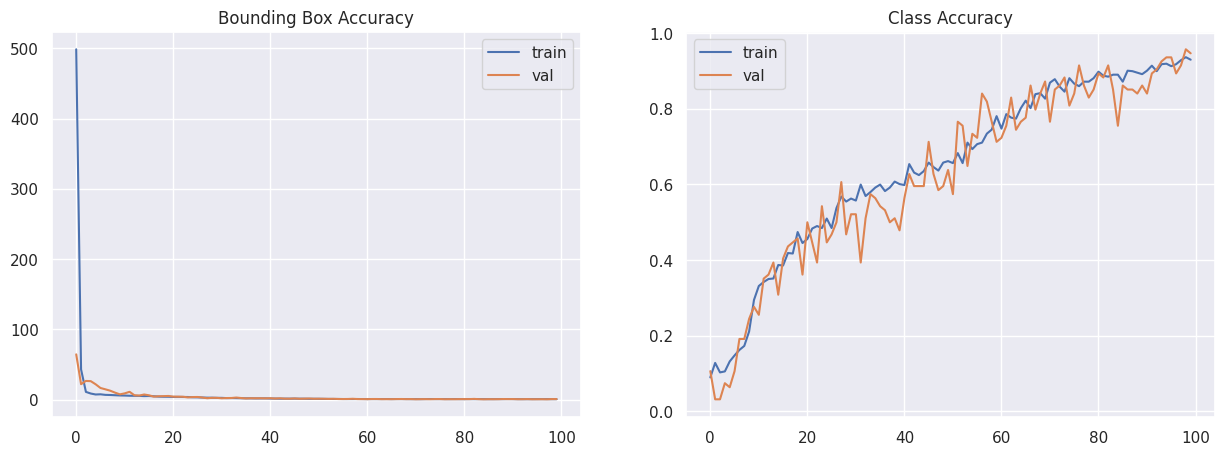

In [33]:
# plot learning curves
history = model.history.history
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history['bbox_output_mse'], label='train')
ax[0].plot(history['val_bbox_output_mse'], label='val')
ax[0].set_title('Bounding Box Accuracy')
ax[0].legend()


ax[1].plot(history['class_output_accuracy'], label='train')
ax[1].plot(history['val_class_output_accuracy'], label='val')
ax[1].set_title('Class Accuracy')
ax[1].legend()

plt.show()

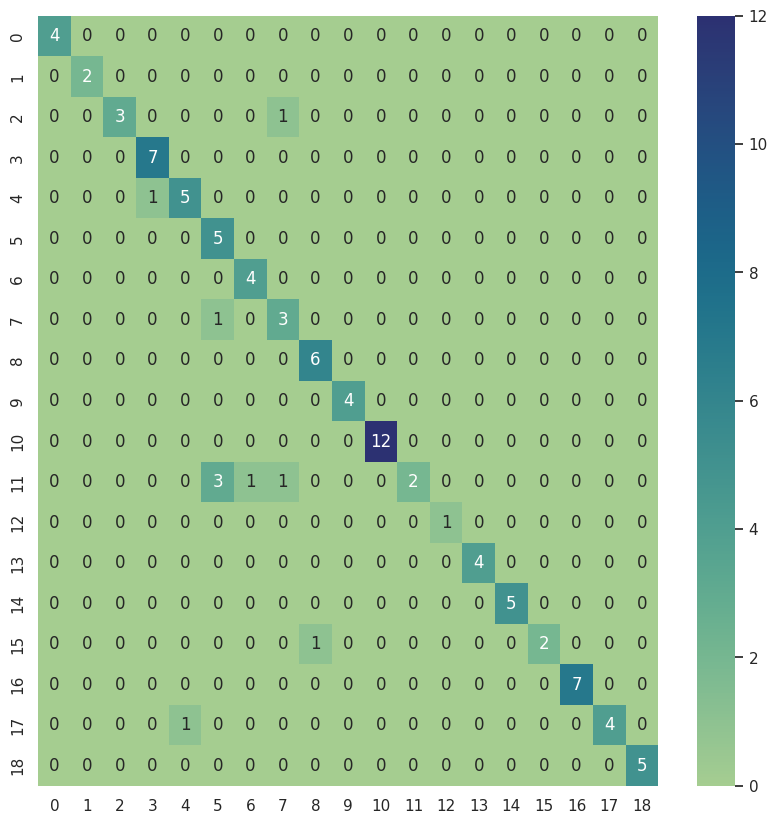

In [34]:
# plotting confusion matrices
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    # Run model → returns (class_pred, bbox_pred)
    class_logits, _ = model.predict(batch_images, verbose=0)

    # True labels
    y_true.extend(batch_labels["class_output"].numpy())

    # Convert softmax → predicted class index
    batch_pred = np.argmax(class_logits, axis=1)
    y_pred.extend(batch_pred)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="crest")
plt.show()

## Plotting images with bounding boxes and predicted classes

In [35]:
def denormalize_bbox(bbox, img_width, img_height):
    x1 = int(bbox[0] * img_width)
    y1 = int(bbox[1] * img_height)
    x2 = int(bbox[2] * img_width)
    y2 = int(bbox[3] * img_height)

    return x1, y1, x2, y2


def plot_prediction(filepath, image, true_label=None, true_bbox=None):
    # Load + preprocess
    img_bytes = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_bytes, channels=3)

    img_batch = tf.expand_dims(image, axis=0)    # shape (1, H, W, 3)

    # Run model
    pred_class_probs, pred_bbox = model.predict(img_batch, verbose=0)
    pred_class_id = pred_class_probs.argmax(axis=1)[0]
    pred_class_name = label_encoder.inverse_transform([pred_class_id])[0]
    pred_top_prob = pred_class_probs[0][pred_class_id]

    # Convert normalized predicted bbox → pixels
    pred_bbox = pred_bbox[0]
    x1, y1, x2, y2 = denormalize_bbox(pred_bbox, IMAGE_SIZE[0], IMAGE_SIZE[1])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img.numpy())
    ax.title.set_text(f"Predicted: {pred_class_name}")

    # Predicted bbox in red
    rect = patches.Rectangle(
        (x1, y1),
        (x2 - x1),
        (y2 - y1),
        linewidth=2,
        edgecolor="red",
        facecolor="none",
        label="Predicted"
    )
    ax.add_patch(rect)

    # Ground truth bbox (optional, if provided)
    if true_bbox is not None:
        tx1, ty1, tx2, ty2 = denormalize_bbox(true_bbox, IMAGE_SIZE[0], IMAGE_SIZE[1])
        rect_gt = patches.Rectangle(
            (tx1, ty1),
            (tx2 - tx1),
            (ty2 - ty1),
            linewidth=2,
            edgecolor="green",
            facecolor="none",
            label="Ground Truth"
        )
        ax.add_patch(rect_gt)

    true_label = label_encoder.inverse_transform([true_label])[0]
    ax.set_title(f"Prediction: {pred_class_name}, Actual: {true_label}")
    ax.axis("off")
    plt.legend()
    plt.show()

b'/content/dataset/Set1/1.02-Agouti/SEQ76129/SEQ76129_IMG_0003.JPG'


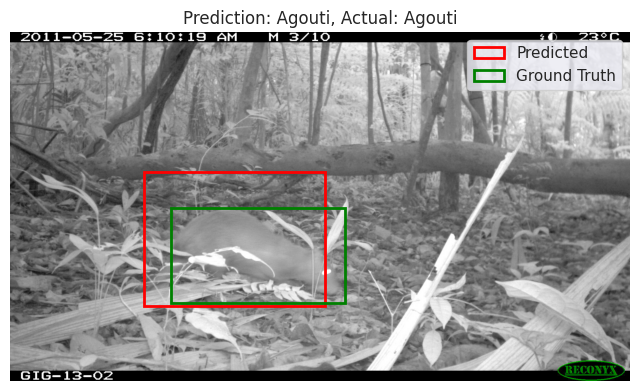

In [36]:
skip_n = np.random.randint(val_size)
image, label, filepath = ds.skip(skip_n).take(1).as_numpy_iterator().next()

print(filepath)
plot_prediction(filepath, image, true_label=label["class_output"], true_bbox=label["bbox_output"])